# Compressed spectrum features [2]

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import pandas as pd
from scipy import stats
import glob
import pickle
from scipy.interpolate import griddata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import dlib

from google.colab import drive
from skimage.morphology import convex_hull_image
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from sklearn.neural_network import MLPClassifier
def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.
    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr
    return radial_prof

In [43]:
def load_facedetector():
    """Loads dlib face and landmark detector."""
    root_dir = "/content/drive/MyDrive/Colab Notebooks/Deep Fake - PDBR/Face warp artifacts experiment/dlib_model"
    if not os.path.isfile(root_dir+'/shape_predictor_68_face_landmarks.dat'):
        print ('Could not find shape_predictor_68_face_landmarks.dat.')
        exit(-1)
    face_detector = dlib.get_frontal_face_detector()
    sp68 = dlib.shape_predictor(root_dir+'/shape_predictor_68_face_landmarks.dat')

    return face_detector, sp68

face_detector, sp68 = load_facedetector()

In [44]:
def shape_to_np(shape):
    number_of_points = shape.num_parts
    points = np.zeros((number_of_points, 2), dtype=np.int32)
    for i in range(0, number_of_points):
        points[i] = (shape.part(i).x, shape.part(i).y)

    return points
def get_crops_landmarks(facedetector, sp68, img, roi_delta=0.0, min_score=0.0):
    """Detects faces and landmarks in image, crops image to face region."""
    face_crops = []
    final_landmarks = []

    dets, scores, idx = facedetector.run(img, 0, 0)

    num_faces = len(dets)
    if num_faces == 0:
        return face_crops, final_landmarks

    # extract especially frontal faces
    if min_score > 0.0:
        dets_new = []
        for i in range(len(dets)):
            if scores[i] > min_score:
                dets_new.append(dets[i])
        dets = dets_new

    # detect landmarks and transform to np array
    landmarks = []
    for detection in dets:
        sp_result = sp68(img, detection)
        landmarks.append(shape_to_np(sp_result))

    # crop faces
    for num in range(len(dets)):
        # copy landmarks and get crop
        face_roi = dets[num]
        face_roi = dlib.rectangle(max(0, face_roi.left()), max(0, face_roi.top()), max(0, face_roi.right()),
                                 max(0, face_roi.bottom()))

        # extend face ROI if needed
        delta_percent = roi_delta
        height = face_roi.bottom() - face_roi.top()
        delta = int(delta_percent * height)
        extended_roi_top = np.clip(face_roi.top() - delta, 0, img.shape[0])
        extended_roi_bottom = np.clip(face_roi.bottom() + delta, 0, img.shape[0])
        extended_roi_left = np.clip(face_roi.left() - delta, 0, img.shape[1])
        extended_roi_right = np.clip(face_roi.right() + delta, 0, img.shape[1])
        cropped_face = img[extended_roi_top:extended_roi_bottom, extended_roi_left:extended_roi_right, :]

        face_landmarks = landmarks[num].copy()

        face_landmarks[:, 0] = face_landmarks[:, 0] - extended_roi_left
        face_landmarks[:, 1] = face_landmarks[:, 1] - extended_roi_top

        final_landmarks.append(face_landmarks)
        face_crops.append(cropped_face)

    return face_crops, final_landmarks

In [ ]:
% cd /content/drive/MyDrive/Colab Notebooks/Deep Fake - PDBR/CODE/TASK_1

/content/drive/.shortcut-targets-by-id/1hMajpu3lOFIQtcgOnINnNkd6M7Xf_-Tu/CODE/TASK_1


In [45]:
import cv2
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
import pickle
from scipy.interpolate import griddata

data= {}
epsilon = 1e-8
N = 300
y = []
error = []

number_iter = 380

psd1D_total = np.zeros([number_iter, N])
label_total = np.zeros([number_iter])
psd1D_org_mean = np.zeros(N)
psd1D_org_std = np.zeros(N)


cont = 0

#fake data
rootdir = '/content/drive/MyDrive/Colab Notebooks/Deep Fake - PDBR/data/Task_1_original/Task_1/development/fake'

for subdir, dirs, files in os.walk(rootdir):
    for file in files:        

        filename = os.path.join(subdir, file)
        
        img2 = cv2.imread(filename,0)
        #print("original: ",img2.shape)

        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        extend_roi = 0.0

        face_crops, final_landmarks = get_crops_landmarks(face_detector, sp68, img2,
                                                    roi_delta=extend_roi)
        img2 = np.array(face_crops)
        if len(img2.shape) < 4:
          #print("no face detected")
          psd1D_total[cont,:] = 0             
          label_total[cont] = 0
          cont = cont+1
          #print(psd1D_total[cont,:])
          #discard_fake = discard_fake+1
        elif len(img2.shape) == 4:
          img2 = np.squeeze(img2)
          img2 = img2[:,:,0]
          #print("cropped: ",img2.shape)
          
          h = int(img2.shape[0]/3)
          w = int(img2.shape[1]/3)
          img2 = img2[h:-h,w:-w]
          #print(img2.shape)
          #plt.imshow(img)
          f = np.fft.fft2(img2)
          fshift = np.fft.fftshift(f)

          magnitude_spectrum = 20*np.log(np.abs(fshift))
          psd1D = azimuthalAverage(magnitude_spectrum)

          # Calculate the azimuthally averaged 1D power spectrum
          points = np.linspace(0,N,num=psd1D.size) # coordinates of a
          xi = np.linspace(0,N,num=N) # coordinates for interpolation

          interpolated = griddata(points,psd1D,xi,method='cubic')
          interpolated /= interpolated[0]

          psd1D_total[cont,:] = interpolated             
          label_total[cont] = 0
          cont+=1
        if cont == number_iter:
            break
    if cont == number_iter:
        break


## real data
psd1D_total2 = np.zeros([number_iter, N])
label_total2 = np.zeros([number_iter])
psd1D_org_mean2 = np.zeros(N)
psd1D_org_std2 = np.zeros(N)

cont = 0

rootdir = '/content/drive/MyDrive/Colab Notebooks/Deep Fake - PDBR/data/Task_1_original/Task_1/development/real'

for subdir, dirs, files in os.walk(rootdir):
    for file in files:        

        filename = os.path.join(subdir, file)
        
        img2 = cv2.imread(filename,0)
        #print("original: ",img2.shape)

        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        extend_roi = 0.0
        face_crops, final_landmarks = get_crops_landmarks(face_detector, sp68, img2,
                                                    roi_delta=extend_roi)
        img2 = np.array(face_crops)
        #print(img2)
        #print(filename)

        if len(img2.shape) < 4:
          #print("no face detected")
          psd1D_total2[cont,:] = 0             
          label_total2[cont] = 0
          cont = cont+1
          #print(psd1D_total[cont,:])
        elif len(img2.shape) == 4:
          img2 = np.squeeze(img2)
          img2 = img2[:,:,0]
          #print("cropped: ",img2.shape)
          
          h = int(img2.shape[0]/3)
          w = int(img2.shape[1]/3)
          img2 = img2[h:-h,w:-w]
          #print(img2.shape)
          #plt.imshow(img)
          f = np.fft.fft2(img2)
          fshift = np.fft.fftshift(f)

          magnitude_spectrum = 20*np.log(np.abs(fshift))
          psd1D = azimuthalAverage(magnitude_spectrum)

          # Calculate the azimuthally averaged 1D power spectrum
          points = np.linspace(0,N,num=psd1D.size) # coordinates of a
          xi = np.linspace(0,N,num=N) # coordinates for interpolation

          interpolated = griddata(points,psd1D,xi,method='cubic')
          interpolated /= interpolated[0]
          # 
          psd1D_total2[cont,:] = interpolated             
          label_total2[cont] = 1
          cont+=1
        if cont == number_iter:
            break
    if cont == number_iter:
        break


for x in range(N):
    psd1D_org_mean2[x] = np.mean(psd1D_total2[:,x])
    psd1D_org_std2[x]= np.std(psd1D_total2[:,x])


y.append(psd1D_org_mean)
y.append(psd1D_org_mean2)

error.append(psd1D_org_std)
error.append(psd1D_org_std2)

psd1D_total_final2 = np.concatenate((psd1D_total,psd1D_total2), axis=0)
label_total_final2 = np.concatenate((label_total,label_total2), axis=0)

data["data"] = psd1D_total_final2
data["label"] = label_total_final2

output = open('training.pkl', 'wb')
pickle.dump(data, output)
output.close()

print("DATA Saved") 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


DATA Saved


In [46]:
data= {}
epsilon = 1e-8
N = 300
y = []
error = []


discard_real = 0
discard_fake = 0


number_iter_real = 110
number_iter_fake = 100

psd1D_total = np.zeros([number_iter_fake, N])
label_total = np.zeros([number_iter_fake])
psd1D_org_mean = np.zeros(N)
psd1D_org_std = np.zeros(N)

cont = 0

#fake data
rootdir = '/content/drive/MyDrive/Colab Notebooks/Deep Fake - PDBR/data/Task_1_original/Task_1/evaluation/fake'

for subdir, dirs, files in os.walk(rootdir):
    for file in files:        

        filename = os.path.join(subdir, file)
        
        img2 = cv2.imread(filename,0)
        #print("original: ",img.shape)

        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        extend_roi = 0.0
        face_crops, final_landmarks = get_crops_landmarks(face_detector, sp68, img2,
                                                    roi_delta=extend_roi)
        img2 = np.array(face_crops)
        #print(filename)
        if len(img2.shape) < 4:
          #print("no face detected on fake")
          discard_fake = discard_fake +1
          psd1D_total[cont,:] = 0             
          label_total[cont] = 0
          cont = cont+1 
          #print("{}, {}".format(cont,filename))   
        elif len(img2.shape) == 4:
          img = np.squeeze(img2)
          img = img[:,:,0]
          #print("cropped: ",img2.shape)
          h = int(img.shape[0]/3)
          w = int(img.shape[1]/3)
          img = img[h:-h,w:-w]
          f = np.fft.fft2(img)
          fshift = np.fft.fftshift(f)

          magnitude_spectrum = 20*np.log(np.abs(fshift))
          psd1D = azimuthalAverage(magnitude_spectrum)

          # Calculate the azimuthally averaged 1D power spectrum
          points = np.linspace(0,N,num=psd1D.size) # coordinates of a
          xi = np.linspace(0,N,num=N) # coordinates for interpolation

          interpolated = griddata(points,psd1D,xi,method='cubic')
          interpolated /= interpolated[0]

          psd1D_total[cont,:] = interpolated             
          label_total[cont] = 0
          cont+=1
        if cont == number_iter_fake:
            break
    if cont == number_iter_fake:
        break

## real data
psd1D_total2 = np.zeros([number_iter_real, N])
label_total2 = np.zeros([number_iter_real])
psd1D_org_mean2 = np.zeros(N)
psd1D_org_std2 = np.zeros(N)


cont = 0
rootdir2 = '/content/drive/MyDrive/Colab Notebooks/Deep Fake - PDBR/data/Task_1_original/Task_1/evaluation/real'
aux = 0

for subdir, dirs, files in os.walk(rootdir2):
    for file in files:  

        filename = os.path.join(subdir, file)
        
        img2 = cv2.imread(filename,0)
        #print("original: ",img.shape)

        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        extend_roi = 0.0
        face_crops, final_landmarks = get_crops_landmarks(face_detector, sp68, img2,
                                                    roi_delta=extend_roi)
        img2 = np.array(face_crops)
        #print(img2.shape)
        if len(img2.shape) < 4:
          #print("no face detected on real")
          discard_real = discard_real+1
          psd1D_total2[cont,:] = 0             
          label_total2[cont] = 0
          cont = cont+1
          #print("{}, {}".format(cont,filename))
        elif len(img2.shape) == 4:
          img = np.squeeze(img2)
          img = img[:,:,0]
          #print("cropped: ",img2.shape)
          h = int(img.shape[0]/3)
          w = int(img.shape[1]/3)
          img = img[h:-h,w:-w]
          f = np.fft.fft2(img)
          fshift = np.fft.fftshift(f)

          magnitude_spectrum = 20*np.log(np.abs(fshift))
          psd1D = azimuthalAverage(magnitude_spectrum)

          # Calculate the azimuthally averaged 1D power spectrum
          points = np.linspace(0,N,num=psd1D.size) # coordinates of a
          xi = np.linspace(0,N,num=N) # coordinates for interpolation

          interpolated = griddata(points,psd1D,xi,method='cubic')
          interpolated /= interpolated[0]

          psd1D_total2[cont,:] = interpolated             
          label_total2[cont] = 1
          cont+=1
        if cont == number_iter_real:
            break
    if cont == number_iter_real:
        break

for x in range(N):
    psd1D_org_mean2[x] = np.mean(psd1D_total2[:,x])
    psd1D_org_std2[x]= np.std(psd1D_total2[:,x])


y.append(psd1D_org_mean)
y.append(psd1D_org_mean2)

error.append(psd1D_org_std)
error.append(psd1D_org_std2)

psd1D_total_final = np.concatenate((psd1D_total,psd1D_total2), axis=0)
label_total_final = np.concatenate((label_total,label_total2), axis=0)

data["data"] = psd1D_total_final
data["label"] = label_total_final

output = open('testing_t1.pkl', 'wb')
pickle.dump(data, output)
output.close()

print("DATA Saved") 

print('Discarded eval real', discard_real)
print('Discarded eval fake', discard_fake)

# 68 43 26 56 201 250
# 44 45 46 47 48 49

DATA Saved
Discarded eval real 9
Discarded eval fake 0


(760,)


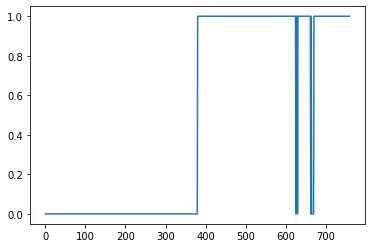

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

# load feature file
pkl_file = open('training.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X = data["data"]
y = data["label"]

plt.plot(y)
X.shape[0]
print(y.shape)

(760, 300)
(760,)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


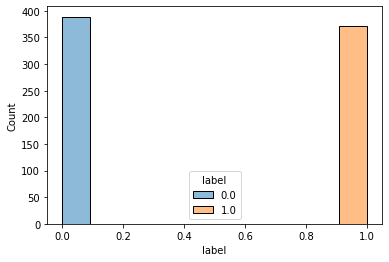

In [73]:

print(X.shape)
print(y.shape)

x_train = pd.DataFrame(X)
y_train = pd.DataFrame(y)
df_Train = []
df_Train = x_train
df_Train['label'] = y_train

df_Train.groupby("label").count()

import seaborn as sns

sns.histplot(data = df_Train, x="label",hue="label", color="skyblue",label ="labels",kde=True)

In [ ]:
df_Train.groupby(["label"]).count()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,...,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389
1.0,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,...,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371


In [ ]:
df_Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Columns: 301 entries, 0 to label
dtypes: float64(301)
memory usage: 1.7 MB


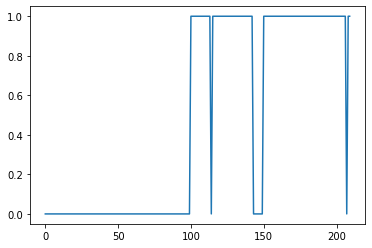

In [74]:
pkl_file = open('testing_t1.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X_ = data["data"]
y_ = data["label"]


plt.plot(y_)

(210, 300)
(210,)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


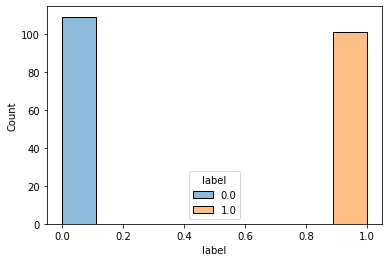

In [75]:

print(X_.shape)
print(y_.shape)

x_test = pd.DataFrame(X_)
y_test = pd.DataFrame(y_)
df_Test = []
df_Test = x_test
df_Test['label'] = y_test

df_Test.groupby("label").count()

import seaborn as sns

sns.histplot(data = df_Test, x="label",hue="label", color="skyblue",label ="labels",kde=True)

In [76]:
# Drop rows corresponding to discarded instances
#df_Train = df_Train[(df_Train.T != 0).any()]
#df_Test = df_Test[(df_Test.T != 0).any()]

X_training = df_Train.loc[:, df_Train.columns != 'label']

X_testing  = df_Test.loc[:, df_Test.columns != 'label']

svclassifier_r = SVC(C=6.37, kernel='rbf', gamma=0.86,probability=True)
svclassifier_r.fit(X_training, df_Train["label"])
y_pred = svclassifier_r.predict(X_testing)

print("svc acc:  ",accuracy_score(df_Test["label"], y_pred))
print("(SVC) - AUC: ", roc_auc_score(df_Test["label"], y_pred))


In [67]:
discard_real = 9
discard_fake = 0
# Add the real test instances discarded
if discard_real > 0 :
  real_lab = pd.DataFrame(np.zeros((discard_real, 1)))
  y_test = pd.concat([df_Test["label"], real_lab], ignore_index=True)

# Add the fake test instances discarded
if discard_fake > 0 : 
  fake_lab = pd.DataFrame(np.ones((discard_fake, 1)))
  y_test = pd.concat([df_Test["label"], fake_lab], ignore_index=True)

# Predict all discarded as real
tot_dis = discard_fake + discard_real
y_pred = np.concatenate([y_pred, np.zeros((tot_dis,))])

In [60]:
print("svc acc:  ",accuracy_score(y_test, y_pred))
print("(SVC) - AUC: ", roc_auc_score(y_test, y_pred))

svc acc:   0.7808219178082192
(SVC) - AUC:  0.7951837556637019


In [79]:
probs1_train = svclassifier_r.predict_proba(X_training)[:, 1]
probs1_test = svclassifier_r.predict_proba(X_testing)[:, 1]

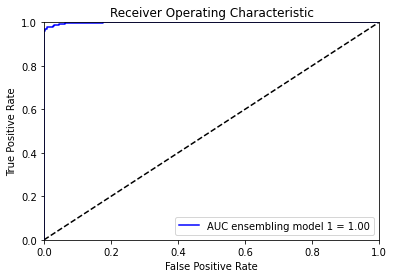

In [55]:

from sklearn.metrics import roc_curve, auc
import sklearn.metrics as metrics

fpr_final1_train, tpr_final1_train, threshold_final1_train    = metrics.roc_curve( df_Train["label"], probs1_train)

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr_final1_train, tpr_final1_train, 'b', label   = 'AUC ensembling model 1 = %0.2f' % roc_auc_score( df_Train["label"], probs1_train))

plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.show()

In [77]:
y_test

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
205,1.0
206,1.0
207,0.0
208,1.0


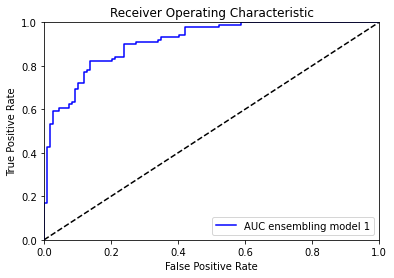

In [82]:

from sklearn.metrics import roc_curve, auc
import sklearn.metrics as metrics

fpr_final1_train, tpr_final1_train, threshold_final1_train    = metrics.roc_curve( y_test, probs1_test)

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr_final1_train, tpr_final1_train, 'b', label   = 'AUC ensembling model 1' % roc_auc_score( y_test, probs1_test))

plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.show()

In [ ]:
for i in np.arange(6, 7, 0.1):
  X_training = df_Train.loc[:, df_Train.columns != 'label']

  X_testing  = df_Test.loc[:, df_Test.columns != 'label']

  svclassifier_r = SVC(C=i, kernel='rbf', gamma=0.86)
  svclassifier_r.fit(X_training, df_Train["label"])
  y_pred = svclassifier_r.predict(X_testing)

    # Add the real test instances discarded
  if discard_real > 0 :
    real_lab = pd.DataFrame(np.zeros((discard_real, 1)))
    y_test = pd.concat([df_Test["label"], real_lab], ignore_index=True)

  # Add the fake test instances discarded
  if discard_fake > 0 : 
    fake_lab = pd.DataFrame(np.ones((discard_fake, 1)))
    y_test = pd.concat([df_Test["label"], fake_lab], ignore_index=True)

  # Predict all discarded as real
  tot_dis = discard_fake + discard_real
  y_pred = np.concatenate([y_pred, np.zeros((tot_dis,))])

  print('(C)({}) - Accuracy: {}  AUC:{}'.format(i, accuracy_score(y_test, y_pred),roc_auc_score(y_test, y_pred)))

(C)(6.0) - Accuracy: 0.7808219178082192  AUC:0.7951837556637019
(C)(6.1) - Accuracy: 0.7808219178082192  AUC:0.7951837556637019
(C)(6.199999999999999) - Accuracy: 0.7808219178082192  AUC:0.7951837556637019
(C)(6.299999999999999) - Accuracy: 0.7808219178082192  AUC:0.7951837556637019
(C)(6.399999999999999) - Accuracy: 0.7808219178082192  AUC:0.7951837556637019
(C)(6.499999999999998) - Accuracy: 0.7808219178082192  AUC:0.7951837556637019
(C)(6.599999999999998) - Accuracy: 0.7808219178082192  AUC:0.7951837556637019
(C)(6.6999999999999975) - Accuracy: 0.7808219178082192  AUC:0.7951837556637019
(C)(6.799999999999997) - Accuracy: 0.7808219178082192  AUC:0.7951837556637019
(C)(6.899999999999997) - Accuracy: 0.7808219178082192  AUC:0.7951837556637019


In [ ]:
from sklearn.tree  import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

covariates1 = X_training.columns#[~X.columns.isin(['L1','L2','L3','L4','L5','L6','L7','L8','L9'])]
print(covariates1)

clf_rf = RandomForestClassifier(n_estimators=600, max_depth=7, random_state=0)

clf_rf.fit(X_training, df_Train["label"])

y_pred = clf_rf.predict(X_testing)

discard_real = 9
discard_fake = 0
# Add the real test instances discarded
if discard_real > 0 :
  real_lab = pd.DataFrame(np.zeros((discard_real, 1)))
  y_test = pd.concat([df_Test["label"], real_lab], ignore_index=True)

# Add the fake test instances discarded
if discard_fake > 0 : 
  fake_lab = pd.DataFrame(np.ones((discard_fake, 1)))
  y_test = pd.concat([df_Test["label"], fake_lab], ignore_index=True)

# Predict all discarded as real
tot_dis = discard_fake + discard_real
y_pred = np.concatenate([y_pred, np.zeros((tot_dis,))])

print('{} - Accuracy: {}  AUC:{}'.format(i, accuracy_score(y_test, y_pred),roc_auc_score(y_test, y_pred)))

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       290, 291, 292, 293, 294, 295, 296, 297, 298, 299],
      dtype='object', length=300)
6.899999999999997 - Accuracy: 0.7671232876712328  AUC:0.7817586843430105


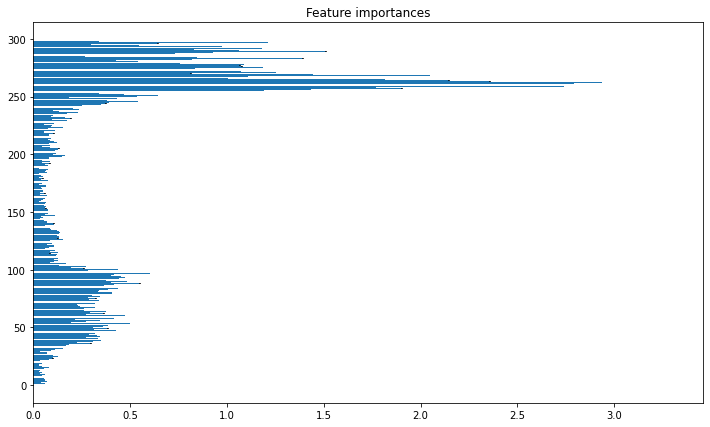

In [ ]:
importances = clf_rf.feature_importances_
puntajes = []
for i,v in enumerate(importances):
  #aux = [i,100*v]
  puntajes.append(100*v)
	#print('Feature: %0d, Score: %.5f' % (i,100*v))
  
# plot feature importance
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)
indices = np.argsort(importances)

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(12,7))
plt.title("Feature importances")
plt.barh(X_training[covariates1].columns[indices], 100*importances[indices], yerr=std[indices], align="center")
plt.show()

In [ ]:
selecto = []
for i in range(300):

  aux = puntajes[i]>0.01
  if aux:
    selecto.append(i)

In [ ]:
x_train = X_training.iloc[:, selecto]
y_train = df_Train["label"]

x_test = df_Test.iloc[:, selecto]
#x_test = input_test.iloc[:, [2, 6, 7, 8, 9]]
y_test = df_Test["label"]

svclassifier_r = SVC(C=6.37, kernel='rbf', gamma=0.86)
svclassifier_r.fit(x_train, y_train)


y_pred = svclassifier_r.predict(x_test)


print("X {} y {}".format(x_train.shape,y_train.shape))
print("X_t {} y_ {}".format(x_test.shape,y_test.shape))


print("svc acc:  ",accuracy_score(y_test, y_pred))
print("(SVC) - AUC: ", roc_auc_score(y_test, y_pred))

X (760, 299) y (760,)
X_t (210, 299) y_ (210,)
svc acc:   0.7714285714285715
(SVC) - AUC:  0.7790898355890634


In [ ]:
discard_real = 9
discard_fake = 0
# Add the real test instances discarded
if discard_real > 0 :
  real_lab = pd.DataFrame(np.zeros((discard_real, 1)))
  y_test = pd.concat([df_Test["label"], real_lab], ignore_index=True)

# Add the fake test instances discarded
if discard_fake > 0 : 
  fake_lab = pd.DataFrame(np.ones((discard_fake, 1)))
  y_test = pd.concat([df_Test["label"], fake_lab], ignore_index=True)

# Predict all discarded as real
tot_dis = discard_fake + discard_real
y_pred = np.concatenate([y_pred, np.zeros((tot_dis,))])


print("y_pred {} y_est {}".format(y_pred.shape,y_test.shape))

print("svc acc:  ",accuracy_score(y_test, y_pred))
print("(SVC) - AUC: ", roc_auc_score(y_test, y_pred))

y_pred (219,) y_est (219, 1)
svc acc:   0.7808219178082192
(SVC) - AUC:  0.7951837556637019
